In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import os

from tqdm import tqdm

### Getting the data and splitting into test, train and validation

In [30]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

data_dir = os.path.join(os.getcwd(), 'Large')

# augment the data, convert it to a normalized torch.FloatTensor and resize it 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Resize((120, 120)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Get the entire dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
print(f'Dataset length: {len(full_dataset)}')
# Splitting the full dataset into training and testing
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

# specify the image classes
classes = ['Bicycle', 'Bus', 'Car', 'Hydrant', 'Palm', 'Traffic Light']

Dataset length: 5531


### Visualize the training data

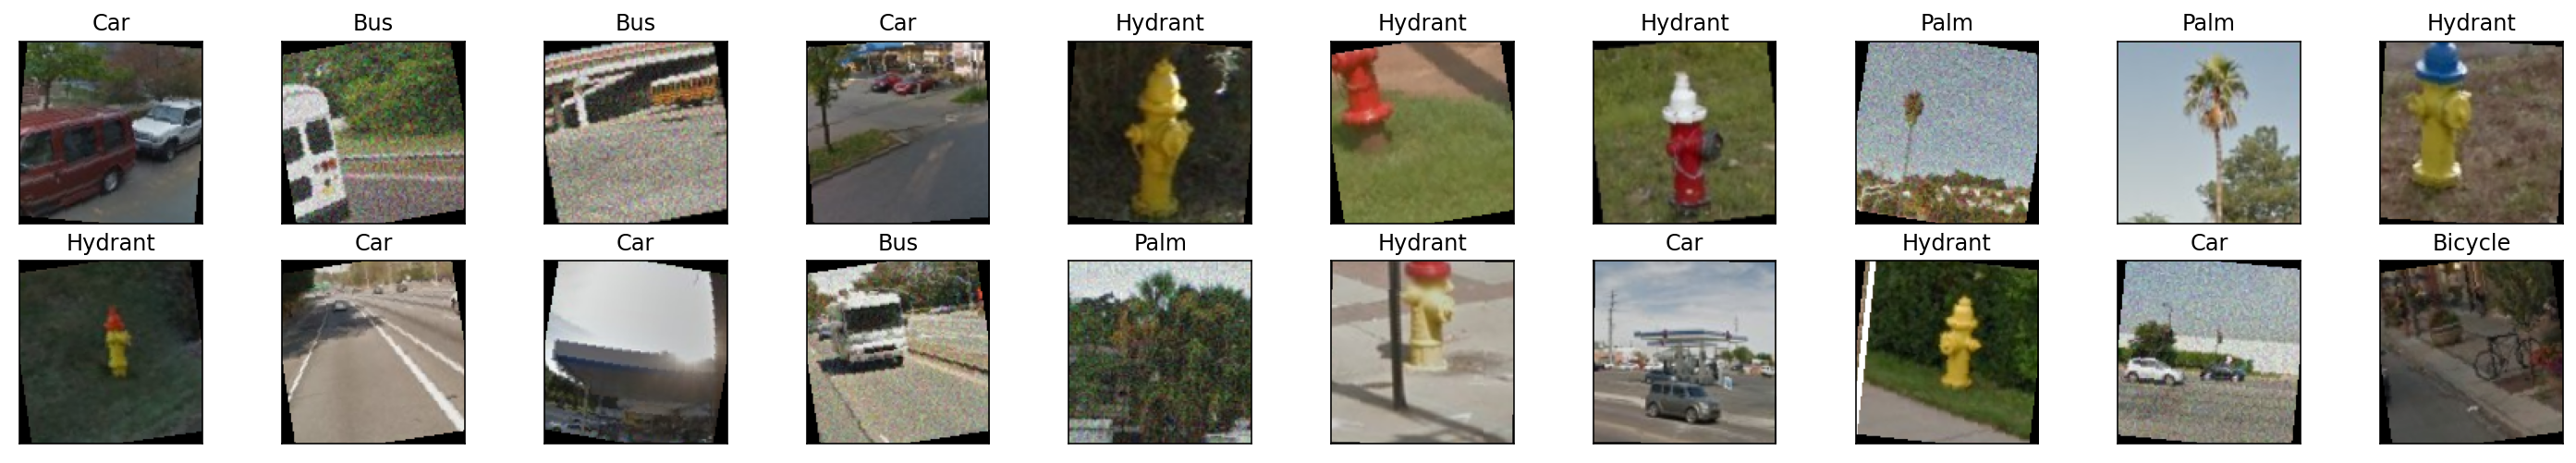

In [25]:
# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
  
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [19]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the pre-trained VGG16 model from torchvision.models and print the architecture
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Andrii_Syd/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
# Freeze parameters so we don't backprop through them --> this speeds up the training time
for param in model.parameters():
    param.requires_grad = False

# We need to create a new classifier because we only have 5 output features
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096), 
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 1000), 
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1000, 6))

# Defining our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

# Move model to device
model.to(device);

### Train the Model

In [32]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
    model.train()
    loop = tqdm(enumerate(train_loader), total = len(train_loader), position=0, leave=False)
    for batch_idx, (data, target) in loop:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)    
        # update progress bar
        loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
        loop.set_postfix(loss = loss.item())

    # validate the model 
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training and validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.904469 	Validation Loss: 0.582604
Validation loss decreased (inf --> 0.582604).  Saving model ...


Epoch: 2 	Training Loss: 0.673564 	Validation Loss: 0.521370
Validation loss decreased (0.582604 --> 0.521370).  Saving model ...


Epoch: 3 	Training Loss: 0.608287 	Validation Loss: 0.607966


Epoch: 4 	Training Loss: 0.575034 	Validation Loss: 0.509624
Validation loss decreased (0.521370 --> 0.509624).  Saving model ...


Epoch: 5 	Training Loss: 0.575974 	Validation Loss: 0.528935


Epoch: 6 	Training Loss: 0.548590 	Validation Loss: 0.491073
Validation loss decreased (0.509624 --> 0.491073).  Saving model ...


Epoch: 7 	Training Loss: 0.517167 	Validation Loss: 0.527213


Epoch: 8 	Training Loss: 0.507307 	Validation Loss: 0.478963
Validation loss decreased (0.491073 --> 0.478963).  Saving model ...


Epoch: 9 	Training Loss: 0.467035 	Validation Loss: 0.496898


Epoch: 10 	Training Loss: 0.508159 	Validation Loss: 0.479071


### Load Model with the Lowest Validation Loss

In [34]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

### Test the Model

In [38]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to ground truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device == "cuda" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item() 
        class_total[label] += 1 

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.729144

Test Accuracy of Bicycle: 81% (66/81)
Test Accuracy of   Bus: 82% (69/84)
Test Accuracy of   Car: 81% (84/103)
Test Accuracy of Hydrant: 97% (103/106)
Test Accuracy of  Palm: 75% (78/103)

Test Accuracy (Overall): 82% (455/554)


### Visualize Test Sample Results

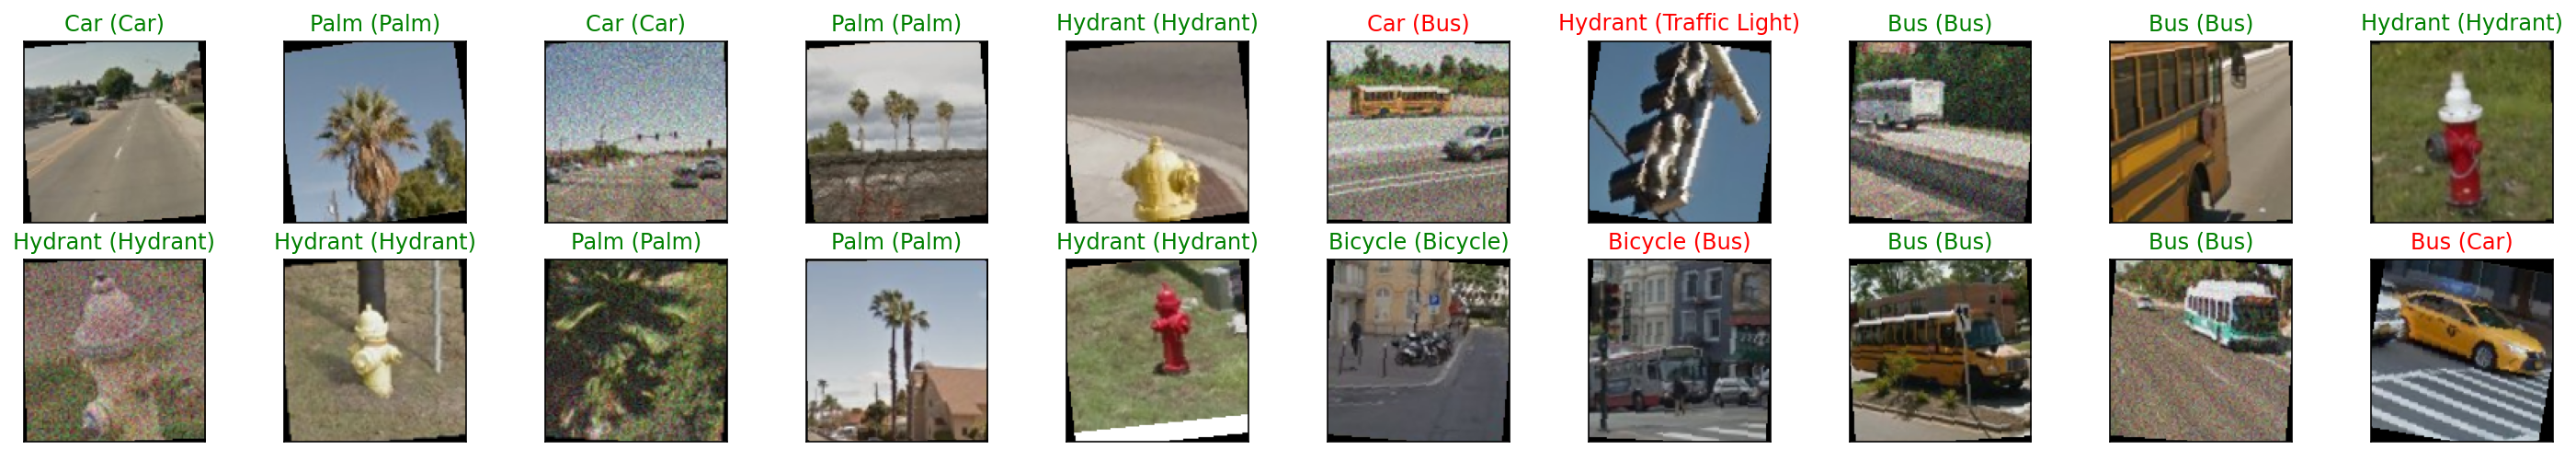

In [39]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device == "cuda" else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))